In [1]:
%matplotlib notebook
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import CenterCrop, ToTensor, Compose, Resize
from torchvision.datasets import ImageFolder
from matplotlib import pyplot as plt
from tqdm import trange

torch.manual_seed(69)

In [2]:
transforms = Compose([CenterCrop((500, 500)), Resize((225, 225)), ToTensor()])
train_imgs = ImageFolder(
    root='./dataset/training/training',
    transform=transforms
)
test_imgs = ImageFolder(
    root='./dataset/validation/validation',
    transform=transforms
)   
BS = 120
train_dtld = DataLoader(train_imgs,
                       shuffle=True,
                       batch_size=BS)
test_dtld = DataLoader(test_imgs,
                      shuffle=True,
                      batch_size=BS)

In [3]:
for x, y in train_dtld:
    plt.imshow(torch.movedim(x[0], 0, 2))
    break

<IPython.core.display.Javascript object>

In [49]:
class BobNet(nn.Module):
    def __init__(self):
        super(BobNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=5, stride=4),
            nn.MaxPool2d(3, stride=2),
            nn.BatchNorm2d(48),
            nn.Conv2d(48, 48, kernel_size=3),
            nn.MaxPool2d(3, stride=2),
            nn.BatchNorm2d(48),
            nn.Conv2d(48, 92, kernel_size=3),
            nn.MaxPool2d(3, stride=2),
            nn.BatchNorm2d(92),
        )
        self.flat = nn.Flatten()
        self.l = nn.Sequential(
            nn.Linear(1472, 1024),
            nn.Dropout(), 
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(), 
            nn.LeakyReLU(),
            nn.Linear(512, 10),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.flat(x)
        return self.l(x)
model = BobNet()

<IPython.core.display.Javascript object>


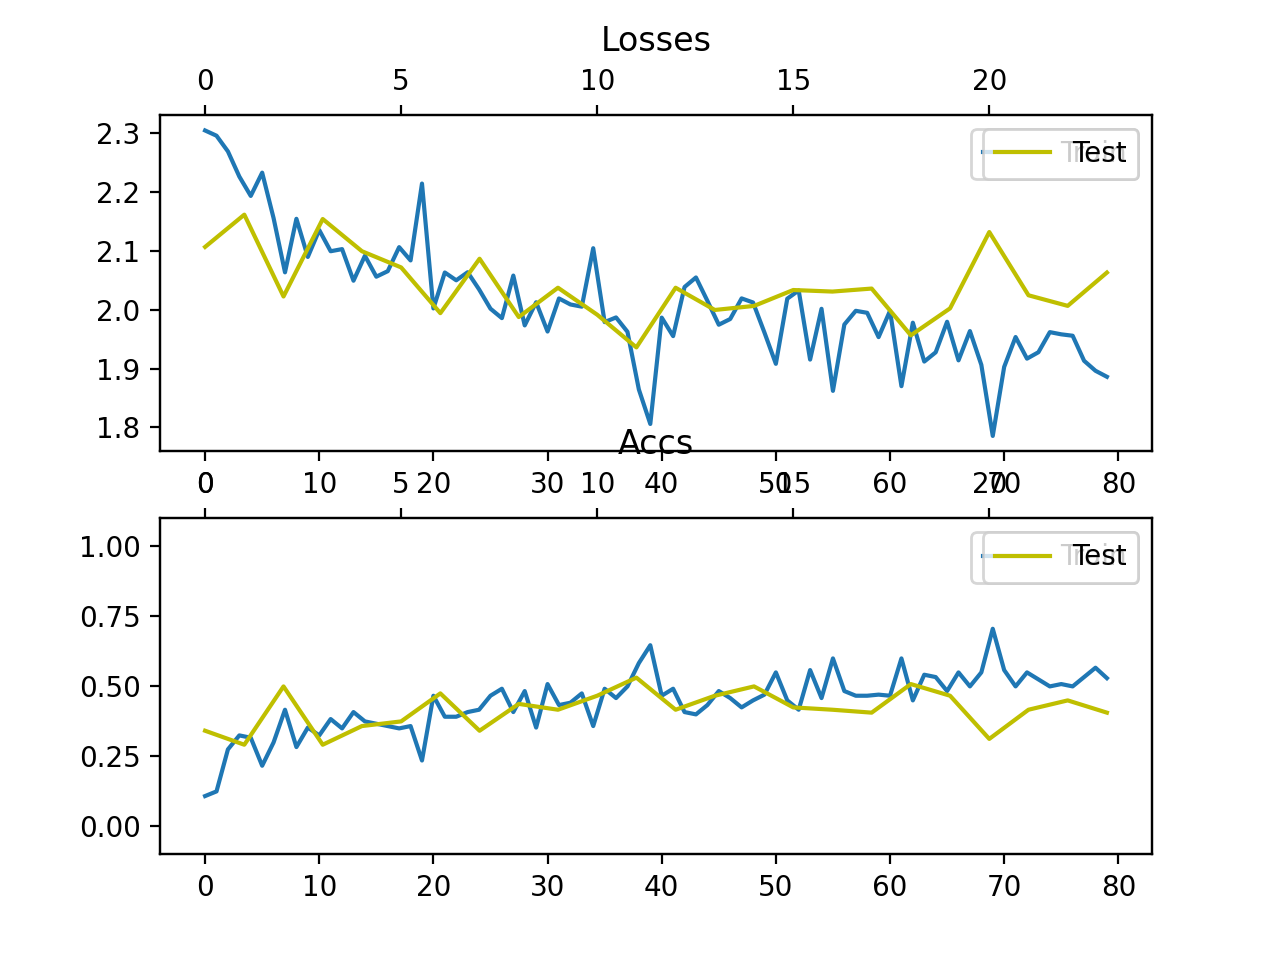

In [50]:
fig, axs = plt.subplots(2,1)
test_axs = (axs[0].twiny(), axs[1].twiny())

In [ ]:
epochs = 50
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn  = nn.CrossEntropyLoss()
test_losses, test_accs = [], []
train_losses, train_accs = [], []

def plot():       
    axs[0].clear()
    test_axs[0].clear()
    axs[0].plot(train_losses, label='Train')
    test_axs[0].plot(test_losses, 'y', label='Test')
    axs[0].set_title('Losses')
    axs[0].legend()
    test_axs[0].legend()

    axs[1].clear()
    test_axs[1].clear()
    axs[1].plot(train_accs, label='Train')
    test_axs[1].plot(test_accs, 'y', label='Test')
    axs[1].set_ylim(-.1, 1.1)
    axs[1].set_title('Accs')
    axs[1].legend()
    test_axs[1].legend()
    fig.canvas.draw()

def do_epoch(dtld, train=True):
    for X, Y in dtld:
        for p in model.parameters():
            p.grad = None
        #Fordward
        pred = model(X)
        Y_hat = torch.argmax(pred, dim=1)
        acc = (Y_hat == Y).float().mean()
        loss = loss_fn(pred, Y)
        # Backward
        if train:
            loss.backward()
            optim.step()
        # Save data
        loss = loss.item(); acc = acc.item()
        if train:
            train_losses.append(loss), train_accs.append(acc)
            t.set_description(f'TRAIN Loss={loss:.2f} Acc={acc:.2f}')
        else:
            test_losses.append(loss), test_accs.append(acc)
            t.set_description(f'TEST Loss={loss:.2f} Acc={acc:.2f}')
        plot()

for _ in (t:=trange(epochs)):
    do_epoch(train_dtld)
    do_epoch(test_dtld, train=False)

TEST Loss=2.06 Acc=0.41:  16%|█▌        | 8/50 [02:50<15:01, 21.45s/it] 

In [ ]:
X_test, Y_test = next(iter(test_dtld))
pred = model(X_test)
Y_hat = torch.argmax(pred, dim=1)
acc = (Y_hat == Y_test).float().mean()
acc